In [48]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from root_pandas import read_root, to_root

from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve

from xgboost import XGBClassifier

import ROOT

from tqdm import tqdm
from itertools import islice

from scipy.stats import linregress

In [2]:
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 7)
plt.rcParams['font.size'] = 14

# read and prepare dataset

In [3]:
data_dir = '/home/kheinicke/tank/flavourtagging/'
filenames_2012 = [
    data_dir + 'Bu2JpsiK_MuonTrainingTuple_2012_MD_sweighted_kheinick.root',
    data_dir + 'Bu2JpsiK_MuonTrainingTuple_2012_MU_sweighted_kheinick.root',
]
filenames_2011 = [
    data_dir + 'Bu2JpsiK_MuonTrainingTuple_2011_MD_sweighted_kheinick.root',
    data_dir + 'Bu2JpsiK_MuonTrainingTuple_2011_MU_sweighted_kheinick.root',
]
chunksize = 5000

In [4]:
# just define some keyword arguments for read_root in a separate dict
data_kwargs = dict(
    key='DecayTree',  # the tree name
    columns=['B_OS_Muon*',  # all branches that should be read
             'B_ID',
             'B_PT',
             'SigYield_sw'
            ],
    chunksize=chunksize,  # this will create a generator, yielding subsets with 'chunksize' of the data
    where='(B_LOKI_MASS_JpsiConstr_NoPVConstr>0)',  # a ROOT where selection, does not work with array-variables
    flatten=True  # will flatten the data in the dimension of the first given column
)

In [5]:
# still have to use plain ROOT to get the number of entries...
n_entries = 0
for fn in filenames_2011 + filenames_2012:
    f = ROOT.TFile(fn)
    t = f.Get('DecayTree')
    n_entries += t.GetEntries()

In [6]:
# set maxslices to `None` to read in all data
maxslices = 30

# This will read chunks of the data inside a list comprehension and then concat those to a big dataframe
# note that tqdm is just some boilerplate to generate a progressbar
df_12 = pd.concat([df for df in tqdm(islice(read_root(filenames_2012, **data_kwargs), maxslices),
                                     total=n_entries/chunksize)])
df_11 = pd.concat([df for df in tqdm(islice(read_root(filenames_2011, **data_kwargs), maxslices),
                                     total=n_entries/chunksize)])

 12%|█▏        | 30/242.961 [00:49<05:53,  1.66s/it]
 12%|█▏        | 30/242.961 [01:03<07:41,  2.17s/it]


In [7]:
# both dataset versions have some differences in naming, this can be skipped once the FT Software is more stable
df_11['B_OS_Muon_countTracks'] = df_11.B_OS_Muon_mult
df_11['B_OS_Muon_phiDistance'] = df_11.B_OS_Muon_minPhiDistance

In [8]:
df = pd.concat([df_11, df_12], join='inner')

In [9]:
# set an event_id label to uniquely identify events (should be actual event id information from TupleToolEventInfo)
df['event_id'] = df.B_PT

In [10]:
# this is essentially because there were some default values missing for IPPUs
df.replace(np.inf, 10000, inplace=True)
df.dropna(inplace=True)

In [11]:
# define a target for classification
df['target'] = np.sign(df.B_ID) == np.sign(df.B_OS_Muon_ID)

# use abs(phiDistance)
df.B_OS_Muon_phiDistance = np.abs(df.B_OS_Muon_phiDistance)

In [12]:
# scale the data to make it usable for TMVA aswell
# /= 1000 somehow kills the kernel. Maybe a bug in pandas? UPDATE: should be fixed in the mt-test environment
df.B_OS_Muon_P *= 0.001
df.B_OS_Muon_PT *= 0.001
df.B_PT *= 0.001

In [13]:
def get_event_number(df, weight_column='SigYield_sw'):
    """ Use weighted sums
    """
    return np.sum(df.groupby(df.event_id)[weight_column].first())  # max, min, mean should give the same values here

In [14]:
total_num_pt = len(df)
total_num_events = len(np.unique(df.event_id))
total_num_events_sw = get_event_number(df)
print(total_num_pt, total_num_events, total_num_events_sw)

18572009 300000 280313.948357


# apply muon-specific selections

In [15]:
# this is the list of BDT variables formerly used
classic_MVA_features = [
    'B_OS_Muon_countTracks',  # aka mult
    'B_OS_Muon_P',
    'B_OS_Muon_PT',
    'B_PT',
    'B_OS_Muon_ABS_RecVertexIP',  # aka IPs
    'B_OS_Muon_TRCHI2DOF',
    'B_OS_Muon_PROBNNmu',
    'B_OS_Muon_TRGHP',
    'B_OS_Muon_IPPUs',
]

In [16]:
# define all the classic selections for muon tagger here for a query
queries = [
    'B_OS_Muon_P > 0',
    'B_OS_Muon_PT > 0.5',
    'B_OS_Muon_IsSignalDaughter == 0',
    'B_OS_Muon_phiDistance > 0.005',
    'B_OS_Muon_MuonPIDIsMuon == 1',
    'B_OS_Muon_TRCHI2DOF < 3',
    'B_OS_Muon_RecVertexIP > 0',
    'B_OS_Muon_TRGHP < 0.4',
    'B_OS_Muon_PROBNNmu > 0.35',
    'B_OS_Muon_PROBNNpi < 0.8',
    'B_OS_Muon_PROBNNe < 0.8',
    'B_OS_Muon_PROBNNk < 0.8',
    'B_OS_Muon_PROBNNp < 0.8',
#    'SigYield_sw > 0'
]

In [17]:
# apply query
selected_data = df.query(' and '.join(queries))
labels = selected_data.target

In [18]:
# groupby will group the rows by given column (in this case B_PT is used as there was now event id information)
# .agg(np.argmax) will then call argmax in every group, which will result in the indices of the element with maximum
# transverse momentum
# the reset_index statement is needed to assign a new, unique index value to each row
selected_data.reset_index(drop=True, inplace=True)
max_pt_data = selected_data.iloc[selected_data.groupby('B_PT')['B_OS_Muon_PT'].idxmax()]

# store labels separately
labels = max_pt_data.target

# calculate efficiency of this selection
max_pt_efficiency = get_event_number(max_pt_data) / get_event_number(df)
print('Efficiency {:2.3f}%'.format(100 * max_pt_efficiency))

Efficiency 7.022%


# train the classifier

In [19]:
# split data, label and sWeights into train- and test-data
(train_data, test_data,
 train_labels, test_labels,
 train_weights, test_weights) = train_test_split(max_pt_data, max_pt_data.target, max_pt_data.SigYield_sw, train_size=0.5)

In [135]:
xgb_model = XGBClassifier(max_depth=5, n_estimators=300, learning_rate=0.01, nthread=32, seed=1)

In [136]:
# train with sWeights > 0 data
xgb_model.fit(train_data[train_weights > 0][classic_MVA_features],
              train_labels[train_weights > 0],
              sample_weight=train_weights[train_weights > 0])

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.01, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=300, nthread=32,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=1, silent=True, subsample=1)

In [137]:
# right-tag prediction
probas = xgb_model.predict_proba(test_data[classic_MVA_features])[:, 1]
probas_train = xgb_model.predict_proba(train_data[classic_MVA_features])[:, 1]

In [138]:
auc_score = roc_auc_score(test_labels, probas, sample_weight=test_weights)
auc_score_train = roc_auc_score(train_labels, probas_train, sample_weight=train_weights)

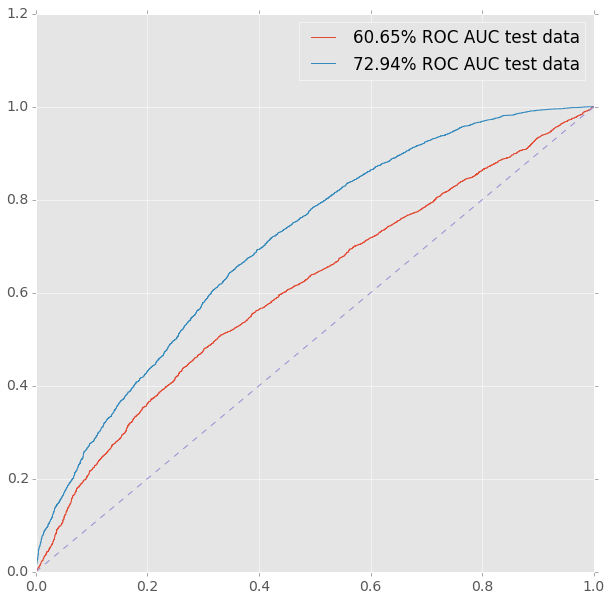

In [139]:
plt.figure(figsize=(10, 10))
plt.plot(*roc_curve(test_labels, probas, sample_weight=test_weights)[:2],
         label='{:2.2f}% ROC AUC test data'.format(100 * auc_score))
plt.plot(*roc_curve(train_labels, xgb_model.predict_proba(train_data[classic_MVA_features])[:, 1],
                    sample_weight=test_weights)[:2],
         label='{:2.2f}% ROC AUC test data'.format(100 * auc_score_train))
plt.plot([0, 1], '--')
plt.legend(loc='best')
plt.show()

In [89]:
def tagging_power_score(y_true, y_score, sample_size, sample_weight=None):
    """Compute per event tagging power
    """
    if sample_weight is None:
        sample_weight = 1

    mistag_estimate = 1 - y_score
    D2s = (1 - 2 * mistag_estimate)**2
    return 1 / sample_size * np.sum(sample_weight * D2s)

In [95]:
power_score = tagging_power_score(test_labels, probas, get_event_number(df), sample_weight=test_weights) 
print('Uncalibrated per sWeighted event tagging power: {:.2f}%'.format(100 * power_score))

Uncalibrated per sWeighted event tagging power: 0.26%


In [96]:
def error_hist(x, bins=30, normed=False, weights=None, density=None, fmt='.', **kwargs):
    y, bin_edges = np.histogram(x, bins=bins, normed=normed, weights=weights, density=density)
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    plt.errorbar(bin_centers, y, np.sqrt(y), fmt=fmt, **kwargs)
    return plt

/home/kheinicke/.local/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


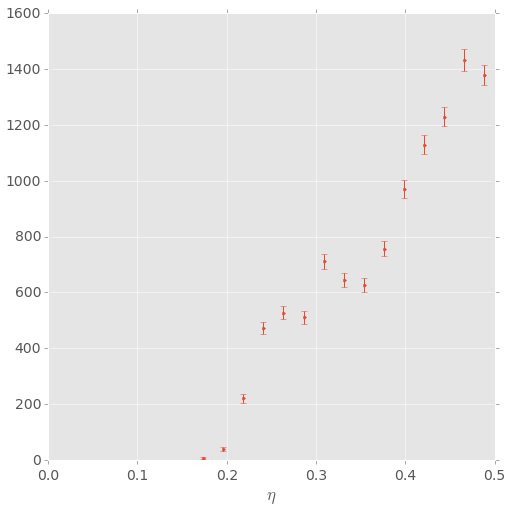

In [97]:
# plot something! here is the eta distribution
etas = np.where(probas >= 0.5, 1 - probas, probas)
plt.figure(figsize=(8, 8))
error_hist(etas, bins=15, label=r'$\eta$ predictions')
plt.xlim(0, 0.5)
plt.xlabel(r'$\eta$')
plt.show()

# calibrate $\eta$

In [98]:
def omega(eta, p0, p1):
    # return eta + p0 + p1 * (eta - eta.mean())
    return p0 + p1 * eta

def Pbb(eta, p0, p1, predicted_labels):
    p = omega(eta, p0, p1)
    return np.where(predicted_labels, 1 - p, p)

In [99]:
from scipy.optimize import curve_fit

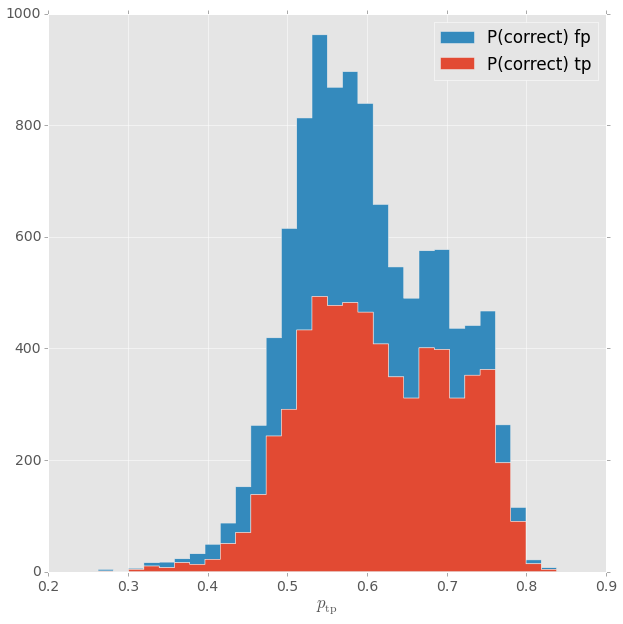

In [100]:
plt.figure(figsize=(10, 10))
p0, p1 = 0, 1
# _, bins, _ = plt.hist(Pbb(etas, p0, p1, probas > 0.5), histtype='stepfilled', alpha=0.5, bins=30)
plt.hist([Pbb(etas, p0, p1, probas > 0.5)[test_labels.values],
          Pbb(etas, p0, p1, probas > 0.5)[~test_labels.values]],
         histtype='stepfilled', bins=30, rwidth=1, stacked=True,
         label=['P(correct) tp', 'P(correct) fp'])
# _, bins, _ = plt.hist(Pbb(etas, p0, p1, probas > 0.5)[test_labels.values], bins=30, alpha=0.5, label='correct P(true)')
# plt.hist(Pbb(etas, p0, p1, probas > 0.5)[~test_labels.values], bins=bins, alpha=0.5, label='incorrect P(true)')
plt.xlabel(r'$p_\mathrm{tp}$')
plt.legend(loc='best')
plt.show()

In [101]:
params, cov = curve_fit(lambda x, a, b: Pbb(x, a, b, test_labels),
                        etas, probas > 0.5, maxfev=5000, p0=[0, 1])

In [102]:
from uncertainties import ufloat

In [103]:
p0, p1 = params
p0err, p1err = np.diag(np.sqrt(cov))
print('p0 = {}, p1 = {}'.format(ufloat(p0, p0err), ufloat(p1, p1err)))
print('Cov:\n', cov)

p0 = -0.051+/-0.023, p1 = 1.17+/-0.06
Cov:
 [[ 0.00054811 -0.00135169]
 [-0.00135169  0.0034714 ]]


In [104]:
params_p, cov_p = curve_fit(omega, probas, test_labels, p0=[probas.mean(), 1], maxfev=2000)

In [105]:
err_p = np.sqrt(np.diag(cov_p))
print(ufloat(params_p[0], err_p[0]),
      ufloat(params_p[1], err_p[1]))
print('Cov:\n', cov_p)

0.043+/-0.031 0.93+/-0.05
Cov:
 [[ 0.00098169 -0.00159828]
 [-0.00159828  0.00266118]]


In [130]:
def proba_bins(x, y_true, errs=True, bins=10, range=(0, 1), sample_weight=None):
    """ Bin data by x and calculate the amount of y_true in each bin,
        errors will be (bin_width/2, sqrt(bin_count))
    """
    if sample_weight is None:
        sample_weight = np.ones(x.shape)
    stepsize = (range[1] - range[0]) / bins
    bin_range = np.arange(range[0], range[1], stepsize)
    xs = [x_ + stepsize/2 for x_ in bin_range]
    true_sums = np.array([np.sum(sample_weight[(x > x_) & (x <= x_+stepsize)]) for x_ in bin_range])
    ys = np.array([np.sum(sample_weight[(x > x_) & (x <= x_+stepsize) & (np.array(y_true) == True)])
          for x_ in bin_range]) / true_sums
    if errs:
        y_errs = np.array([np.sqrt(np.sum(sample_weight[(x > x_) & (x <= x_+stepsize) & (np.array(y_true) == False)]))
                  for x_ in bin_range]) / true_sums
        x_errs = stepsize / 2
        return xs, ys, y_errs, x_errs
    else:
        return xs, ys

/home/kheinicke/.local/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


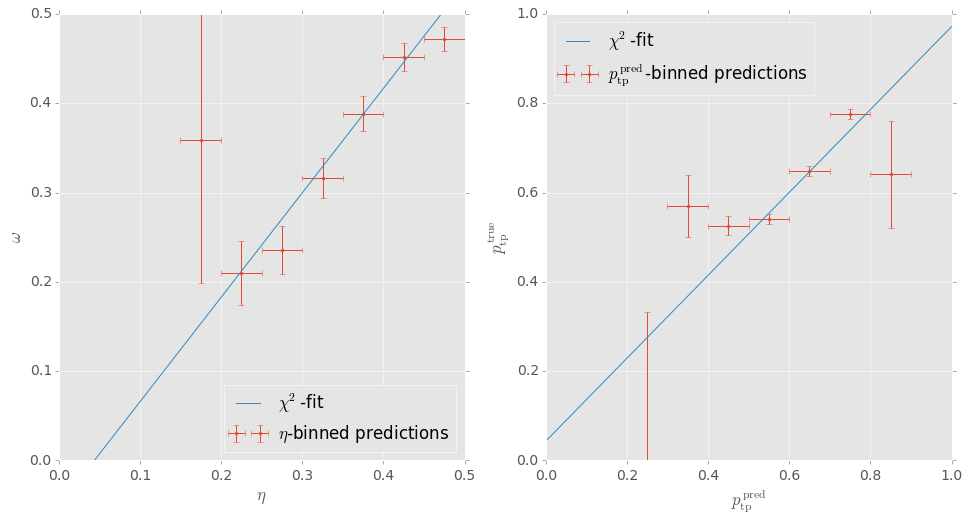

In [131]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.errorbar(*proba_bins(etas, test_data.target == False, range=(0, 0.5), sample_weight=test_weights),
             fmt='.', label=r'$\eta$-binned predictions')
plt.plot([0, 1], omega(np.array([0, 1]), *params), label=r'$\chi^2$-fit')
plt.xlim(0, 0.5)
plt.ylim(0, 0.5)
plt.xlabel(r'$\eta$')
plt.ylabel(r'$\omega$')
plt.legend(loc='best')

plt.subplot(1, 2, 2)
plt.errorbar(*proba_bins(probas, test_data.target, range=(0, 1), sample_weight=test_weights),
             fmt='.', label=r'$p_\mathrm{tp}^\mathrm{pred}$-binned predictions')
plt.plot([0, 1], omega(np.array([0, 1]), *params_p), label=r'$\chi^2$-fit')
plt.xlabel(r'$p_\mathrm{tp}^\mathrm{pred}$')
plt.ylabel(r'$p_\mathrm{tp}^\mathrm{true}$')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend(loc='best')
plt.show()

/home/kheinicke/.local/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


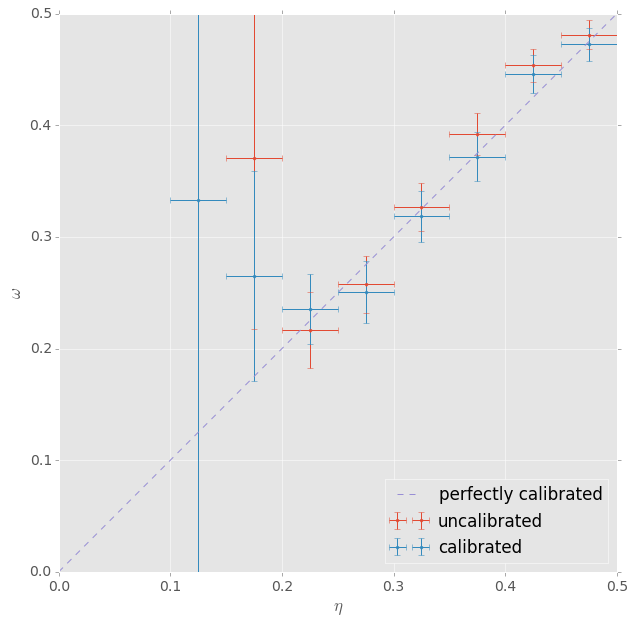

In [132]:
calibrated_etas = omega(etas, *params)
plt.figure(figsize=(10, 10))
plt.errorbar(*proba_bins(etas, test_data.target == False, range=(0, 0.5)),
             fmt='.', label='uncalibrated')
plt.errorbar(*proba_bins(calibrated_etas, test_data.target == False, range=(0, 0.5)),
             fmt='.', label='calibrated')
plt.plot([0, 0.5], [0, 0.5], '--', label='perfectly calibrated')
plt.xlim(0, 0.5)
plt.ylim(0, 0.5)
plt.legend(loc='best')
plt.xlabel(r'$\eta$')
plt.ylabel(r'$\omega$')
plt.show()

In [125]:
# tagging power is even worse, obviously the simple linear calibration is not approprate here
tagging_power_score(test_labels, calibrated_etas, get_event_number(df), sample_weight=test_weights) * 100

0.25249017762706488

In [126]:
tagging_power_score(test_labels, etas, get_event_number(df), sample_weight=test_weights) * 100

0.26272852462176949